## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week3_model_free/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        else:
            value = max([self.get_qvalue(state,action) for action in possible_actions])
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount

        learning_rate = self.alpha
        
        qvalue=self.get_qvalue(state,action)

        self.set_qvalue(state,action,qvalue)

        qvalue=(1-learning_rate)*qvalue + learning_rate*(reward + gamma* self.get_value(next_state))
        
        self.set_qvalue(state,action,qvalue)
    

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None
        else:
            best_action=np.argmax([self.get_qvalue(state,action) for action in possible_actions])
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon
        num_actions=len(possible_actions)

        prob = np.ones(num_actions, 
                dtype = float) * (epsilon) / num_actions 
        
                  
        best_action = self.get_best_action(state)
        prob[best_action] += (1-epsilon) 

        chosen_action = np.random.choice(np.arange( 
                      len(prob)), 
                       p = prob)
        
        return chosen_action

### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [ ]:
import gym
env = gym.make("Taxi-v3")

n_actions = env.action_space.n

In [ ]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [ ]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a =agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)
      
        s = next_s
        total_reward += r
        if done:
            break
    return total_reward

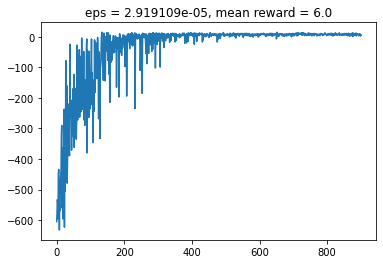

In [ ]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()
        

### Submit to Coursera I: Preparation

In [ ]:
submit_rewards1 = rewards.copy()

# Binarized state spaces

Use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state: [ 0.02374241  0.04354831 -0.01556751  0.00828133]


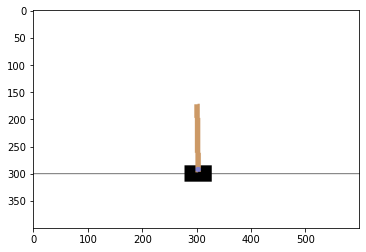

In [ ]:
def make_env():
    return gym.make('CartPole-v0').env  # .env unwraps the TimeLimit wrapper

env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [ ]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)
    
    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    f, axarr = plt.subplots(2, 2, figsize=(16, 9), sharey=True)
    for i, title in enumerate(['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']):
        ax = axarr[i // 2, i % 2]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(title)
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

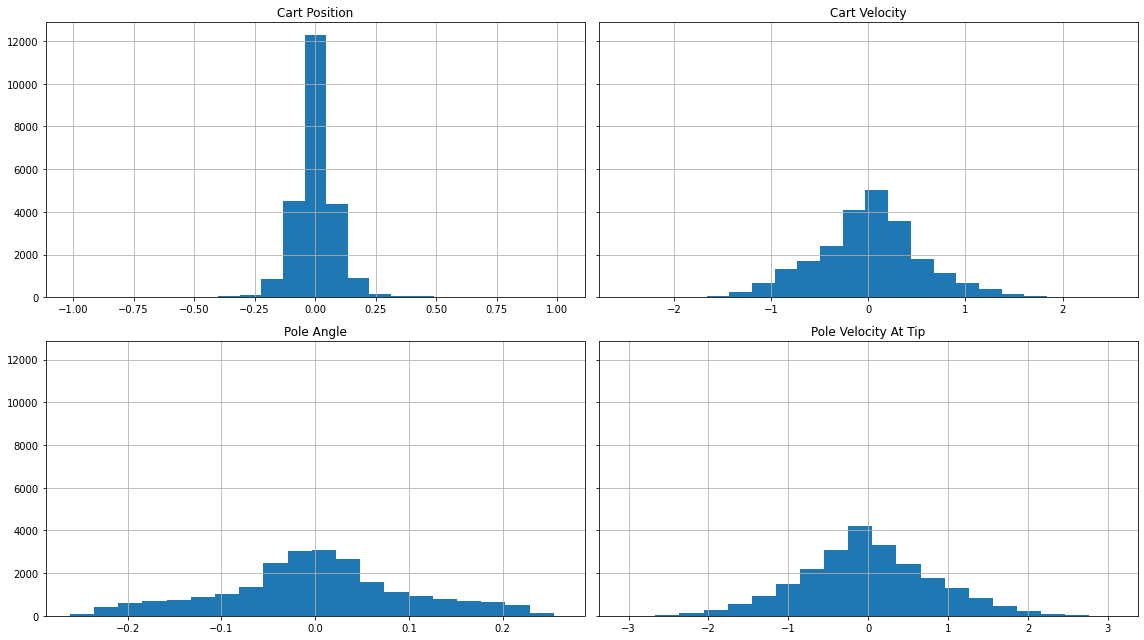

In [ ]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)

visualize_cartpole_observation_distribution(seen_observations)

## Binarize environment

In [ ]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):
    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.
        #state = <YOUR CODE: round state to some amount digits>
        n_digits=1
        state=np.round(np.array(state),n_digits)
        return tuple(state)

In [ ]:
env = Binarizer(make_env())

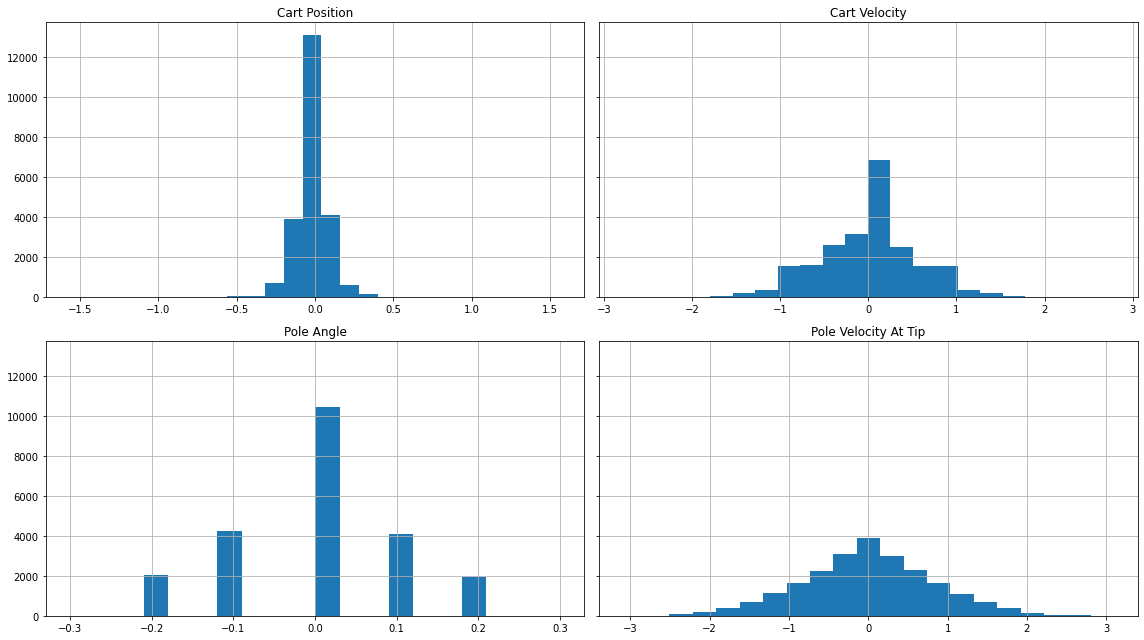

In [ ]:
seen_observations = []
for _ in range(1000):
    seen_observations.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        seen_observations.append(s)
        if done:
            break

visualize_cartpole_observation_distribution(seen_observations)

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your binarization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change binarization. In practice we found that this kind of mistake is rather frequent.
* If your binarization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse binarization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

In [ ]:
import pandas as pd

def moving_average(x, span=100):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span).mean().values

In [ ]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

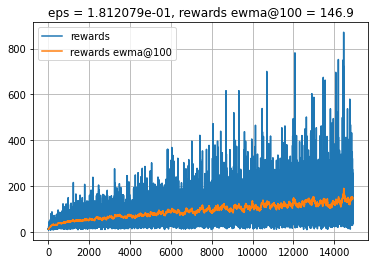

In [ ]:
rewards = []
epsilons = []

for i in range(15000):
    reward = play_and_train(env, agent)
    rewards.append(reward)
    epsilons.append(agent.epsilon)
    
    # OPTIONAL: <YOUR CODE: adjust epsilon>
    if agent.epsilon > np.random.uniform(0,1):
        agent.epsilon*=0.9999

    if i % 100 == 0:
        rewards_ewma = moving_average(rewards)
        
        clear_output(True)
        plt.plot(rewards, label='rewards')
        plt.plot(rewards_ewma, label='rewards ewma@100')
        plt.legend()
        plt.grid()
        plt.title('eps = {:e}, rewards ewma@100 = {:.1f}'.format(agent.epsilon, rewards_ewma[-1]))
        plt.show()

### Submit to Coursera II: Submission

In [ ]:
submit_rewards2 = rewards.copy()

In [ ]:
from submit import submit_qlearning
submit_qlearning(submit_rewards1, submit_rewards2, 'ruperto.bonet@modelphysmat.com', 'yQ8hByFkDL0NP2Z8')

Submitted to Coursera platform. See results on assignment page!
